dataset  
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

In [2]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [29]:
class TextCNN:

    def __init__(
      self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        print(num_filters_total)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)
            
                            # add@@@@@@@@
            features_size = 5
            self.features = tf.Variable(tf.truncated_normal([num_filters_total, features_size], stddev=0.1))
            # 384 * 5
            self.f_h = tf.matmul(self.h_drop, self.features, )
              # (None * 383) *(384 * 5) 
            #print(self.h_drop) #None * 384 
            #print(self.f_h) # None * 5



        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[features_size, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            #W = tf.get_variable("W", shape=[num_filters_total, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            

            
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            #self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.scores = tf.nn.xw_plus_b(self.f_h, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [30]:
# Parameters
# ==================================================

# Data loading params
dev_sample_percentage = 0.0005

positive_data_file = "data/amazon/book_pos.txt"#"./data/rt-polarity.pos"
negative_data_file = "data/amazon/book_neg.txt"#"./data/rt-polarity.neg" #"Data source for the negative data.")
#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

# Model Hyperparameters
embedding_dim = 32     #, "Dimensionality of character embedding (default: 128)")
filter_sizes = "2,3,4,5"        #, "Comma-separated filter sizes (default: '3,4,5')")
num_filters=128               #, "Number of filters per filter size (default: 128)")
dropout_keep_prob=0.5 #, "Dropout keep probability (default: 0.5)")
l2_reg_lambda=0.0          #, "L2 regularization lambda (default: 0.0)")

# Training parameters
batch_size=64                    #, "Batch Size (default: 64)")
num_epochs=200              #, "Number of training epochs (default: 200)")
evaluate_every=100         #, "Evaluate model on dev set after this many steps (default: 100)")
num_checkpoints=5          #, "Number of checkpoints to store (default: 5)")

# Misc Parameters
allow_soft_placement=True    #, "Allow device soft device placement")
log_device_placement=False  #, "Log placement of ops on devices")

#FLAGS = tf.flags.FLAGS
#FLAGS._parse_flags()
#print("\nParameters:")
#for attr, value in sorted(FLAGS.__flags.items()):
#    print("{}={}".format(attr.upper(), value))
#print("")

In [5]:
def load_data_and_labels(positive_data_file, negative_data_file):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    #positive_examples = [s.strip() for s in positive_examples]
    positive_examples = [s.replace(" ", "").replace("", " ") for s in positive_examples]
    
    negative_examples = list(open(negative_data_file, "r").readlines())
    negative_examples = [s.replace(" ", "").replace("", " ") for s in negative_examples]
    #negative_examples = [s.strip() for s in negative_examples]

    x_text = positive_examples + negative_examples
    #x_text = [clean_str(sent) for sent in x_text]

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]

In [6]:
%%notify
x_text, y = load_data_and_labels(positive_data_file, negative_data_file)

<IPython.core.display.Javascript object>

In [7]:
len(x_text)

1000000

In [8]:
x_text[0]

' L o v e t h e c h a r a c t e r s . L o v e t h e l o c a t i o n ! I c a n n o t w a i t f o r t h e n e x t b o o k i n t h e s e r i e s . I w i l l c e r t a i n l y r e a d i t . \n '

In [9]:
length_list = np.array([len(r)for r in x_text])

In [10]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,187
1,399
2,621
3,215
4,225


In [11]:
df.describe()

,length
count,1000000.000000
mean,842.351232
std,1119.140102
min,3.000000
25%,255.000000
50%,447.000000
75%,931.000000
max,48939.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d5174e0>]],
      dtype=object)

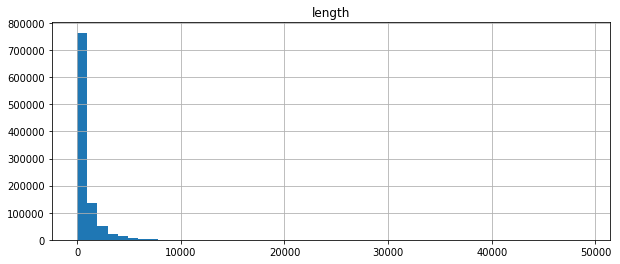

In [12]:
df.hist(bins=50,figsize=(10,4))

In [13]:
x_text = [x[:2000] if len(x) > 2000 else x for x in x_text]

In [14]:
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe()

,length
count,1000000.000000
mean,694.104355
std,584.037875
min,3.000000
25%,255.000000
50%,447.000000
75%,931.000000
max,2000.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28cbf1d0>]],
      dtype=object)

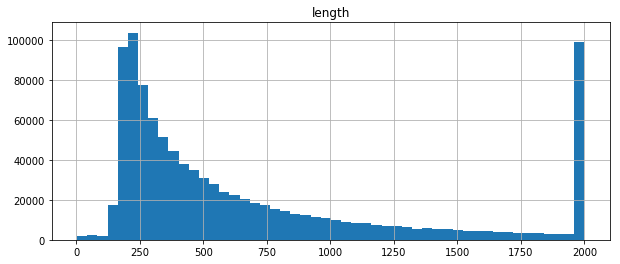

In [15]:
df.hist(bins=50,figsize=(10,4))

In [16]:
#x_text = x_text[:20000]
#y = y[:20000]

In [17]:
lang = "Ja" #"En"

In [18]:
if lang == "En":
    max_document_length = max([len(x.split(" ")) for x in x_text])
elif lang == "Ja":
    max_document_length = max([len(x) for x in x_text])
print("max document length", max_document_length)

max document length 2000


In [19]:
vocab_processor = preprocessing.VocabularyProcessor(max_document_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [20]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [21]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

dev_sample_index = -1 * int(dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]

del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Vocabulary Size: 66
Train/Dev split: 999500/500


<IPython.core.display.Javascript object>

In [22]:
print(x_train.shape)

(999500, 2000)


In [23]:
def save_pickle():
    chunk_size =  int(len(x_train)/10)
    print(chunk_size)
    for i in range(0, len(x_train), chunck_size):
        print(i)
        end = i+chunck_size
        if end < len(x_train):
            chunk = x_train[i:  end]
        else:
            chunk = x_train[i:]
            end = len(x_train)
        with open("data/x_train_{}.pkl".format(end), "wb") as f:
            pickle.dump(chunk, f, protocol = 4)

In [24]:
def load_x_train():
    all_size = 999000
    chunk_size = 99900
    x_train =[]
    for i in range(0, all_size, chunck_size):
        print(i)
        end = i+chunk_size
        if end > len(reviews):
            end = all_size
        with open("data/x_train_{}.pkl".format(end), "rb") as f:
            x_train += pickle.load(f)
        return x_train
#x_train = load_x_train()

In [25]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [31]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)
embedding_size = embedding_dim
filter_sizes = list(map(int, filter_sizes.split(",")))
num_filters = num_filters
l2_reg_lambda = l2_reg_lambda

In [32]:
save_checkpoint = False

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        #timestamp = str(int(time.time()))
        timestamp = "1525408577"
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp, "2-3-4-5"))
        print("Writing to {}\n".format(out_dir))


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)


        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)


        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)


        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

512
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; us

2018-05-06T20:16:40.536709: step 87, loss 1.04111, acc 0.515625
2018-05-06T20:16:41.558761: step 88, loss 0.691799, acc 0.625
2018-05-06T20:16:42.579191: step 89, loss 0.709892, acc 0.640625
2018-05-06T20:16:43.711315: step 90, loss 0.822177, acc 0.546875
2018-05-06T20:16:45.106489: step 91, loss 0.799831, acc 0.59375
2018-05-06T20:16:46.068470: step 92, loss 0.934839, acc 0.546875
2018-05-06T20:16:47.071626: step 93, loss 0.736761, acc 0.671875
2018-05-06T20:16:48.050021: step 94, loss 0.693646, acc 0.625
2018-05-06T20:16:49.030526: step 95, loss 0.921909, acc 0.546875
2018-05-06T20:16:49.954532: step 96, loss 0.895175, acc 0.546875
2018-05-06T20:16:50.931127: step 97, loss 0.804281, acc 0.578125
2018-05-06T20:16:51.918382: step 98, loss 0.838438, acc 0.59375
2018-05-06T20:16:53.229597: step 99, loss 0.888956, acc 0.59375
2018-05-06T20:16:54.502343: step 100, loss 0.903383, acc 0.546875

Evaluation:
2018-05-06T20:16:58.137069: step 100, loss 0.603543, acc 0.606

2018-05-06T20:16:59.14

2018-05-06T20:19:21.964240: step 211, loss 0.750633, acc 0.53125
2018-05-06T20:19:23.429715: step 212, loss 0.679052, acc 0.671875
2018-05-06T20:19:24.819751: step 213, loss 0.540523, acc 0.765625
2018-05-06T20:19:26.141782: step 214, loss 0.637638, acc 0.6875
2018-05-06T20:19:27.482647: step 215, loss 0.594585, acc 0.6875
2018-05-06T20:19:28.858795: step 216, loss 0.603624, acc 0.703125
2018-05-06T20:19:30.087268: step 217, loss 0.635791, acc 0.703125
2018-05-06T20:19:31.336683: step 218, loss 0.715521, acc 0.640625
2018-05-06T20:19:32.651273: step 219, loss 0.629052, acc 0.6875
2018-05-06T20:19:34.029938: step 220, loss 0.532921, acc 0.703125
2018-05-06T20:19:35.169113: step 221, loss 0.541975, acc 0.75
2018-05-06T20:19:36.267420: step 222, loss 0.632615, acc 0.625
2018-05-06T20:19:37.406142: step 223, loss 0.627492, acc 0.71875
2018-05-06T20:19:38.545377: step 224, loss 0.63651, acc 0.671875
2018-05-06T20:19:39.839852: step 225, loss 0.548624, acc 0.703125
2018-05-06T20:19:41.089068

2018-05-06T20:21:51.146074: step 336, loss 0.565287, acc 0.6875
2018-05-06T20:21:52.409568: step 337, loss 0.503581, acc 0.765625
2018-05-06T20:21:53.443897: step 338, loss 0.594657, acc 0.6875
2018-05-06T20:21:54.461533: step 339, loss 0.531223, acc 0.71875
2018-05-06T20:21:55.515223: step 340, loss 0.572277, acc 0.75
2018-05-06T20:21:56.573092: step 341, loss 0.570218, acc 0.703125
2018-05-06T20:21:57.639109: step 342, loss 0.632905, acc 0.65625
2018-05-06T20:21:58.776989: step 343, loss 0.571768, acc 0.671875
2018-05-06T20:21:59.888116: step 344, loss 0.559507, acc 0.796875
2018-05-06T20:22:01.036257: step 345, loss 0.687712, acc 0.609375
2018-05-06T20:22:02.125055: step 346, loss 0.63622, acc 0.640625
2018-05-06T20:22:03.243270: step 347, loss 0.633123, acc 0.640625
2018-05-06T20:22:04.323284: step 348, loss 0.528626, acc 0.734375
2018-05-06T20:22:05.384860: step 349, loss 0.564728, acc 0.6875
2018-05-06T20:22:06.556763: step 350, loss 0.591627, acc 0.703125
2018-05-06T20:22:07.800

2018-05-06T20:24:20.670194: step 462, loss 0.514917, acc 0.75
2018-05-06T20:24:21.858210: step 463, loss 0.480432, acc 0.765625
2018-05-06T20:24:23.037134: step 464, loss 0.671191, acc 0.65625
2018-05-06T20:24:24.248100: step 465, loss 0.503227, acc 0.71875
2018-05-06T20:24:25.412981: step 466, loss 0.474909, acc 0.75
2018-05-06T20:24:26.764764: step 467, loss 0.551119, acc 0.703125
2018-05-06T20:24:27.930405: step 468, loss 0.511406, acc 0.75
2018-05-06T20:24:29.263426: step 469, loss 0.482129, acc 0.734375
2018-05-06T20:24:30.690199: step 470, loss 0.494777, acc 0.78125
2018-05-06T20:24:31.921167: step 471, loss 0.446835, acc 0.8125
2018-05-06T20:24:33.315161: step 472, loss 0.517794, acc 0.75
2018-05-06T20:24:34.912700: step 473, loss 0.511717, acc 0.765625
2018-05-06T20:24:36.278392: step 474, loss 0.594465, acc 0.640625
2018-05-06T20:24:37.762487: step 475, loss 0.545957, acc 0.734375
2018-05-06T20:24:39.144890: step 476, loss 0.668632, acc 0.671875
2018-05-06T20:24:40.415341: ste

char level cnn 
- 1525408577  

Using clean_str  
```
Evaluation:
2018-04-17T10:40:20.162299: step 5000, loss 0.161694, acc 0.942
```

In [ ]:
tf.train.get_checkpoint_state('./runs/1525408577/checkpoints')

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, "runs/1525408577/checkpoints/model-98400")

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]